<a href="https://colab.research.google.com/github/luiseduaardo/PneuModel/blob/main/notebooks/treinamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/luiseduaardo/PneuModel
%cd PneuModel

Cloning into 'PneuModel'...
remote: Enumerating objects: 5886, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 5886 (delta 6), reused 15 (delta 4), pack-reused 5865 (from 3)
Receiving objects: 100% (5886/5886), 1.25 GiB | 40.16 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Updating files: 100% (5863/5863), done.
/content/PneuModel


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.2
)

path_treinamento = "./data/train"

#treino
train_generator = train_datagen.flow_from_directory(
    path_treinamento,
    target_size=(384, 384),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

#validação
val_generator = train_datagen.flow_from_directory(
    path_treinamento,
    target_size=(384, 384),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

In [5]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(384, 384, 3))

base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = [tf.keras.metrics.AUC(name='auc')]
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [7]:
early_stop = EarlyStopping(
    monitor='val_auc',
    patience=5,
    restore_best_weights=True,
    mode='max'
)

checkpoint = ModelCheckpoint(
    './weights/melhor_modelo_pneumonia.h5',
    monitor='val_auc',
    save_best_only=True,
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.2,
    patience=3,
    min_lr=0.00001,
    mode='max'
)

callbacks_list = [early_stop, checkpoint, reduce_lr]

In [8]:
history = model.fit(
    train_generator,
    epochs=20, # Limite alto, mas geralmente o EarlyStopping para antes
    validation_data=val_generator,
    callbacks=callbacks_list
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.9144 - loss: 0.3296

131/131 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - auc: 0.9146 - loss: 0.3292 - val_auc: 0.9512 - val_loss: 0.6041 - learning_rate: 0.0010
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.9623 - loss: 0.2174

131/131 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - auc: 0.9623 - loss: 0.2174 - val_auc: 0.9663 - val_loss: 0.3923 - learning_rate: 0.0010
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.9599 - loss: 0.2222

131/131 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - auc: 0.9599 - loss: 0.2221 - val_auc: 0.9747 - val_loss: 0.3084 - learning_rate: 0.0010
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.9688 - loss: 0.1902

131/131 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - auc: 0.9688 - loss: 0.1901 - val_auc: 0.9768 - val_loss: 0.1885 - learning_rate: 0.0010
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.9732 - loss: 0.1843

131/131 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - auc: 0.9732 - loss: 0.1842 - val_auc: 0.9800 - val_loss: 0.1568 - learning_rate: 0.0010
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.9716 - loss: 0.1876

131/131 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - auc: 0.9716 - loss: 0.1875 - val_auc: 0.9842 - val_loss: 0.1401 - learning_rate: 0.0010
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - auc: 0.9728 - loss: 0.1820 - val_auc: 0.9830 - val_loss: 0.1393 - learning_rate: 0.0010
Epoch 8/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.9816 - loss: 0.1444

131/131 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - auc: 0.9816 - loss: 0.1444 - val_auc: 0.9863 - val_loss: 0.1286 - learning_rate: 0.0010
Epoch 9/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - auc: 0.9767 - loss: 0.1670 - val_auc: 0.9849 - val_loss: 0.1359 - learning_rate: 0.0010
Epoch 10/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.9826 - loss: 0.1459

131/131 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - auc: 0.9826 - loss: 0.1460 - val_auc: 0.9876 - val_loss: 0.1221 - learning_rate: 0.0010
Epoch 11/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - auc: 0.9809 - loss: 0.1519 - val_auc: 0.9853 - val_loss: 0.1448 - learning_rate: 0.0010
Epoch 12/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - auc: 0.9821 - loss: 0.1489 - val_auc: 0.9843 - val_loss: 0.1293 - learning_rate: 0.0010
Epoch 13/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.9814 - loss: 0.1496

131/131 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - auc: 0.9814 - loss: 0.1496 - val_auc: 0.9879 - val_loss: 0.1174 - learning_rate: 0.0010
Epoch 14/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.9776 - loss: 0.1654

131/131 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - auc: 0.9777 - loss: 0.1653 - val_auc: 0.9890 - val_loss: 0.1207 - learning_rate: 0.0010
Epoch 15/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - auc: 0.9805 - loss: 0.1515 - val_auc: 0.9881 - val_loss: 0.1167 - learning_rate: 0.0010
Epoch 16/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.9807 - loss: 0.1489

131/131 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - auc: 0.9807 - loss: 0.1489 - val_auc: 0.9928 - val_loss: 0.1001 - learning_rate: 0.0010
Epoch 17/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - auc: 0.9818 - loss: 0.1486 - val_auc: 0.9891 - val_loss: 0.1158 - learning_rate: 0.0010
Epoch 18/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - auc: 0.9861 - loss: 0.1302 - val_auc: 0.9895 - val_loss: 0.1085 - learning_rate: 0.0010
Epoch 19/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - auc: 0.9815 - loss: 0.1453 - val_auc: 0.9921 - val_loss: 0.0973 - learning_rate: 0.0010
Epoch 20/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - auc: 0.9858 - loss: 0.1318 - val_auc: 0.9876 - val_loss: 0.1117 - learning_rate: 2.0000e-04


In [9]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

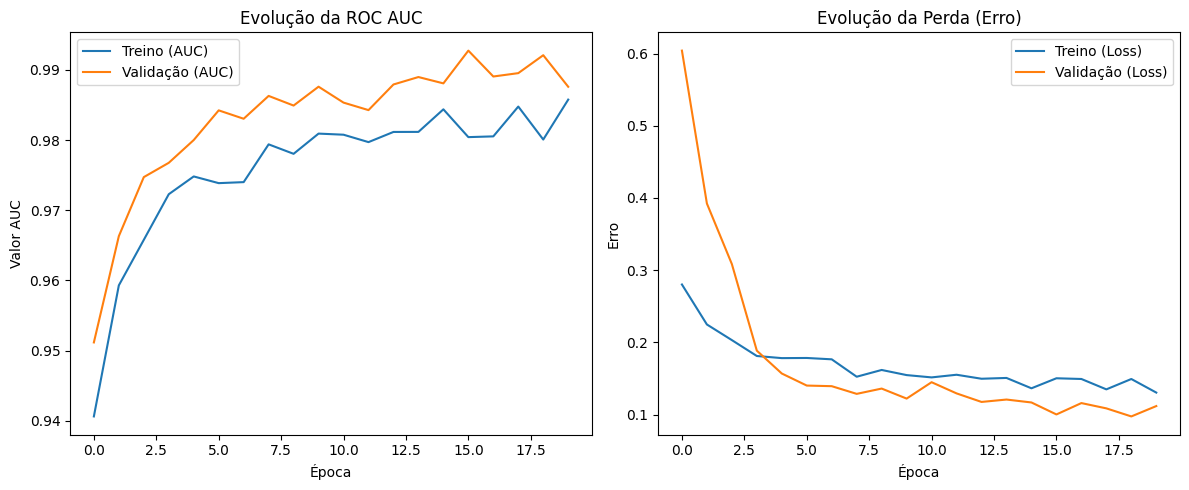

In [10]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['auc'], label='Treino (AUC)')
plt.plot(history.history['val_auc'], label='Validação (AUC)')
plt.title('Evolução da ROC AUC')
plt.xlabel('Época')
plt.ylabel('Valor AUC')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino (Loss)')
plt.plot(history.history['val_loss'], label='Validação (Loss)')
plt.title('Evolução da Perda (Erro)')
plt.xlabel('Época')
plt.ylabel('Erro')
plt.legend()

plt.tight_layout()
plt.show()

33/33 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step


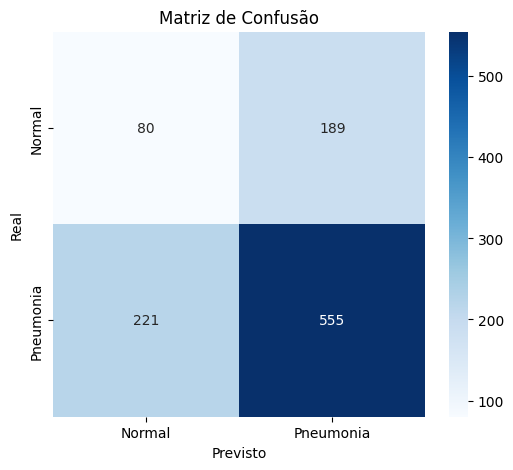

              precision    recall  f1-score   support

      Normal       0.27      0.30      0.28       269
   Pneumonia       0.75      0.72      0.73       776

    accuracy                           0.61      1045
   macro avg       0.51      0.51      0.51      1045
weighted avg       0.62      0.61      0.61      1045



In [11]:
val_generator.reset()
predictions = model.predict(val_generator)

y_pred = (predictions > 0.5).astype(int)
y_true = val_generator.classes

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.ylabel('Real')
plt.xlabel('Previsto')
plt.title('Matriz de Confusão')
plt.show()

print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))